In [ ]:
!pip install pandas
!pip install numpy
!pip install pyarrow
!pip install keras
!pip install scikit-learn
!pip install tensorflow
!pip install matplotlib
!pip install seaborn

In [75]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector, Flatten, Reshape
from keras.callbacks import Callback
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

We will quickly read the data from our ETL pipeline.

In [61]:
x_train = pd.read_csv('data-etl/x_train.csv')
y_train = pd.read_csv('data-etl/y_train.csv')

x_test = pd.read_csv('data-etl/x_test.csv')
y_test = pd.read_csv('data-etl/y_test.csv')

# Model Definition

In [62]:
batch_size = 64
epochs = 50
timesteps = 100
dim = 1

In [63]:
def get_sequences(x, y, timesteps = 1):
    Xs, Ys = [], []
    for i in range(len(x) - timesteps):
        Xs.append(x.iloc[i: (i + timesteps)].values)
        Ys.append(y.iloc[i + timesteps])
        
    return np.array(Xs), np.array(Ys)

In [64]:
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

46783 46783
44991 44991


In [65]:
x_train, y_train = get_sequences(x_train, y_train, timesteps)
x_test, y_test = get_sequences(x_test, y_test, timesteps)

In [66]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
lossHistory = LossHistory()

In [68]:
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, dim)))
model.add(Dropout(0.2))

model.add(RepeatVector(n=timesteps))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(1, activation= 'sigmoid')))
model.compile(loss='mae', optimizer='adam')

# Model Training

In [69]:
def train(train, test):
    model.fit(train, test, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[lossHistory], shuffle=False)

In [70]:
def predict(data):
    return model.predict(data)

In [71]:
train(x_train, y_train)

Epoch 1/50
657/657 [==============================] - 35s 52ms/step - loss: 0.0081 - val_loss: 3.0732e-05
Epoch 2/50
657/657 [==============================] - 33s 50ms/step - loss: 2.8858e-05 - val_loss: 1.2866e-05
Epoch 3/50
657/657 [==============================] - 33s 50ms/step - loss: 1.4229e-05 - val_loss: 6.8516e-06
Epoch 4/50
657/657 [==============================] - 33s 50ms/step - loss: 8.2442e-06 - val_loss: 4.0724e-06
Epoch 5/50
657/657 [==============================] - 33s 49ms/step - loss: 5.1903e-06 - val_loss: 2.5750e-06
Epoch 6/50
657/657 [==============================] - 33s 50ms/step - loss: 3.4180e-06 - val_loss: 1.6939e-06
Epoch 7/50
657/657 [==============================] - 33s 50ms/step - loss: 2.3408e-06 - val_loss: 1.1405e-06
Epoch 8/50
657/657 [==============================] - 33s 50ms/step - loss: 1.6225e-06 - val_loss: 7.8172e-07
Epoch 9/50
657/657 [==============================] - 32s 49ms/step - loss: 1.1459e-06 - val_loss: 5.4179e-07
Epoch 10/50
65

# Model Evaluation

In [76]:
reconstructions_train = predict(x_train)
train_mae = np.mean(np.abs(reconstructions_train - x_train), axis=1)
train_mae

1459/1459 [==============================] - 12s 8ms/step


array([[0.33391369],
       [0.32448143],
       [0.31527437],
       ...,
       [0.07480984],
       [0.07538824],
       [0.07591331]])

<Axes: ylabel='Count'>

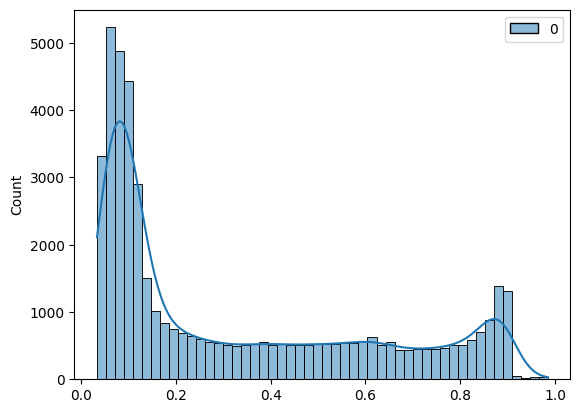

In [79]:
sns.histplot(train_mae, bins = 50, kde=True)

In [80]:
threshold = 1.0

In [81]:
reconstructions_test = predict(x_test)
test_mae = np.mean(np.abs(reconstructions_test - x_test), axis=1)
test_mae

1403/1403 [==============================] - 12s 8ms/step


array([[0.18325474],
       [0.18736046],
       [0.19167123],
       ...,
       [0.07657823],
       [0.07700966],
       [0.07741501]])

In [95]:
x_test = pd.read_csv('data-etl/x_test.csv')
y_test = pd.read_csv('data-etl/y_test.csv')

test_df = pd.DataFrame(index = x_test[timesteps:].index)
test_df['Loss'] = test_mae
test_df['Threshold'] = threshold
test_df['Anomaly'] = test_df.Loss > test_df.Threshold

In [96]:
anomalies = test_df[['Anomaly']]

In [97]:
print(len(anomalies), len(y_test))
y_test

44891 44991


,0.000000000000000000e+00,0.000000000000000000e+00.1
0,10.0,0.0
1,20.0,0.0
2,30.0,0.0
3,40.0,0.0
4,50.0,0.0
...,...,...
44986,449870.0,0.0
44987,449880.0,0.0
44988,449890.0,0.0
44989,449900.0,0.0


In [92]:
print(metrics.classification_report(y_test, anomalies, zero_division=0.0))

ValueError: Classification metrics can't handle a mix of multiclass-multioutput and binary targets